In [1]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'/Users/Downloads/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.bmp'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')
                    img = img.resize((64, 64))
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(label_folder)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = dict(enumerate(class_weights))

# Define data augmentation configuration
datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.1,
    horizontal_flip=False
)
datagen.fit(X_train)

# Parameter combinations using itertools.product
parameter_combinations = list(product([1, 2], [32, 64], [1, 2], [64, 128], [0.1, 0.2, 0.3], [50], [32, 64], [0.001, 0.002], ['relu'], ['adam']))

# Initialize results list
results = []

# Loop over all parameter combinations
for idx, (conv_layers, filters, dense_layers, dense_units, dropout, epochs, batch_size, learning_rate, activation, optimizer) in enumerate(parameter_combinations):
    current_config = {
        'conv_layers': conv_layers,
        'filters': filters,
        'dense_layers': dense_layers,
        'dense_units': dense_units,
        'dropout': dropout,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'activation': activation,
        'optimizer': optimizer
    }
    # print(f"Running configuration {idx+1}/{len(parameter_combinations)}: {current_config}")

    # Define and compile the CNN model
    model = Sequential()
    model.add(InputLayer(input_shape=(64, 64, 1)))
    for _ in range(conv_layers):
        model.add(Conv2D(filters, (3, 3), activation=activation))
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    for _ in range(dense_layers):
        model.add(Dense(dense_units, activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

    # Select optimizer
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    else:
        optimizer_instance = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with data augmentation
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), validation_data=(X_test, y_test), epochs=epochs, class_weight=class_weights_dict, verbose=0)

    # Evaluate the model and store the results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    precision.update_state(true_classes, predicted_classes)
    recall.update_state(true_classes, predicted_classes)
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

    # Store results
    results.append({
        'config': current_config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history  # Save history for later plotting
    })
    print({
        'config': current_config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history  # Save history for later plotting
    })

# Sort results by F1 score in descending order and select the top 15
top_results = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:15]

# Print and plot the top 15 results
for idx, result in enumerate(top_results):
    config = result['config']
    history = result['history']
    print(f"Top {idx+1} Configuration: {config}")
    print(f"Metrics - Accuracy: {result['test_accuracy']*100:.2f}%, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, F1 Score: {result['f1_score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Config {idx+1} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Config {idx+1} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


{'config': {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.7037037014961243, 'precision': 0.9621451, 'recall': 0.8866279, 'f1_score': 0.9228441941236338, 'history': <keras.src.callbacks.history.History object at 0x28f675570>}
{'config': {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.6641975045204163, 'precision': 0.9292035, 'recall': 0.9156977, 'f1_score': 0.9224011936299673, 'history': <keras.src.callbacks.history.History object at 0x29201e2c0>}
{'config': {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.540740728378

2024-08-15 18:39:53.846453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [128]
	 [[{{function_node __inference_one_step_on_data_1639231}}{{node adam/truediv_15}}]]


InvalidArgumentError: Graph execution error:

Detected at node adam/truediv_15 defined at (most recent call last):
  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_911/4247404967.py", line 125, in <module>

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 69, in train_step

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 282, in apply_gradients

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 351, in apply

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py", line 405, in _backend_apply_gradients

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/optimizer.py", line 119, in _backend_update_step

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/optimizer.py", line 135, in _distributed_tf_update_step

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/optimizer.py", line 132, in apply_grad_to_update_var

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/optimizers/adam.py", line 147, in update_step

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 5502, in divide

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/sparse.py", line 780, in sparse_wrapper

  File "/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 2214, in divide

Incompatible shapes: [0] vs. [128]
	 [[{{node adam/truediv_15}}]] [Op:__inference_one_step_on_iterator_1639312]

In [4]:
# Sort results by F1 score in descending order and select the top 15
top_results = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:55]

# Print and plot the top 15 results
for idx, result in enumerate(top_results):
    config = result['config']
    history = result['history']
    print(f"Top {idx+1} Configuration: {config}")
    print(f"Metrics - Accuracy: {result['test_accuracy']*100:.2f}%, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, F1 Score: {result['f1_score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Config {idx+1} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Config {idx+1} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Top 1 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 77.28%, Precision: 0.9597, Recall: 0.9680, F1 Score: 0.9638
Top 2 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 75.31%, Precision: 0.9514, Recall: 0.9680, F1 Score: 0.9597
Top 3 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 75.06%, Precision: 0.9513, Recall: 0.9651, F1 Score: 0.9582
Top 4 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size

Top 1 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 77.28%, Precision: 0.9597, Recall: 0.9680, F1 Score: 0.9638


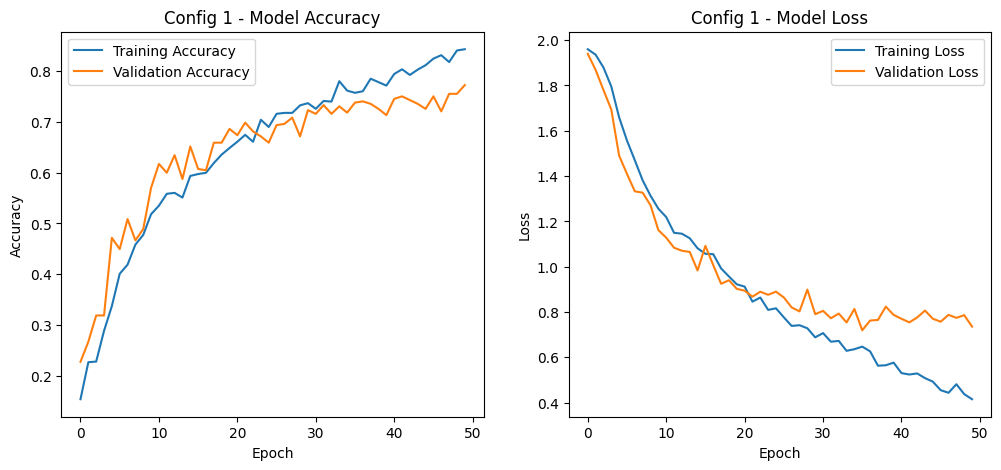

Top 2 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 75.31%, Precision: 0.9514, Recall: 0.9680, F1 Score: 0.9597


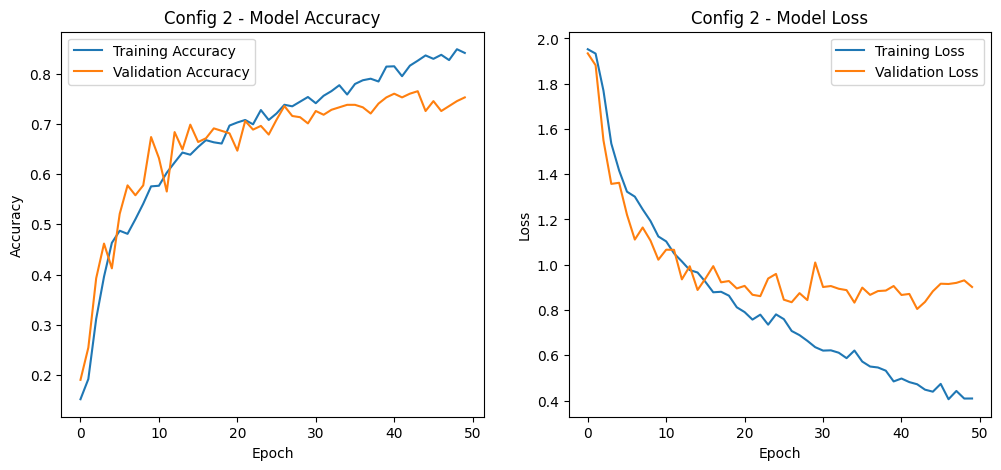

Top 3 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 75.06%, Precision: 0.9513, Recall: 0.9651, F1 Score: 0.9582


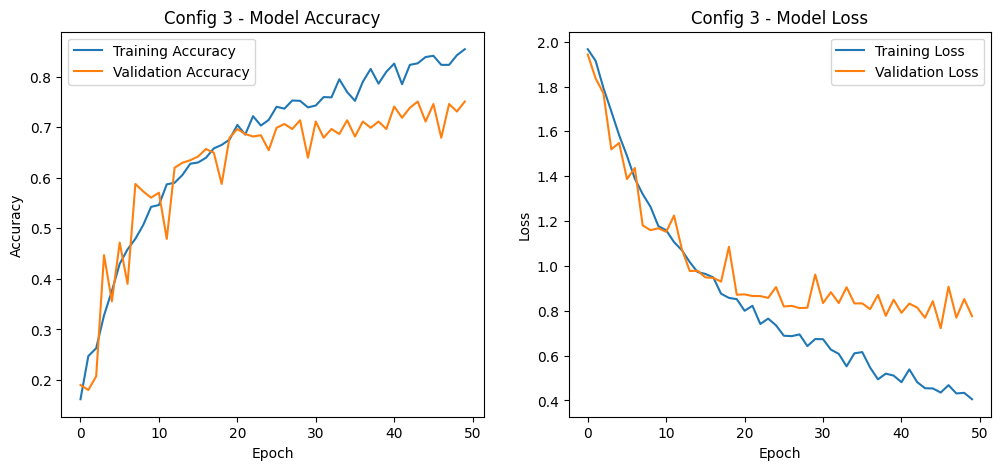

Top 4 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 74.32%, Precision: 0.9539, Recall: 0.9622, F1 Score: 0.9580


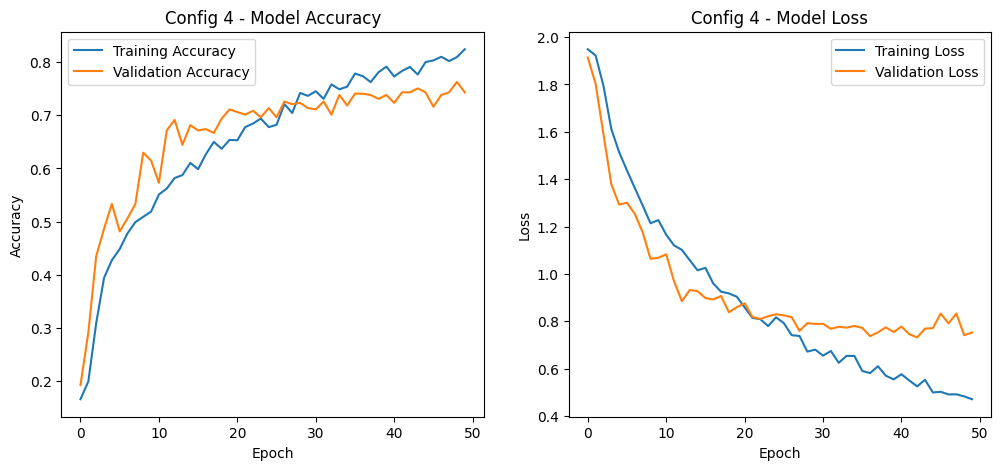

Top 5 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 79.26%, Precision: 0.9592, Recall: 0.9564, F1 Score: 0.9578


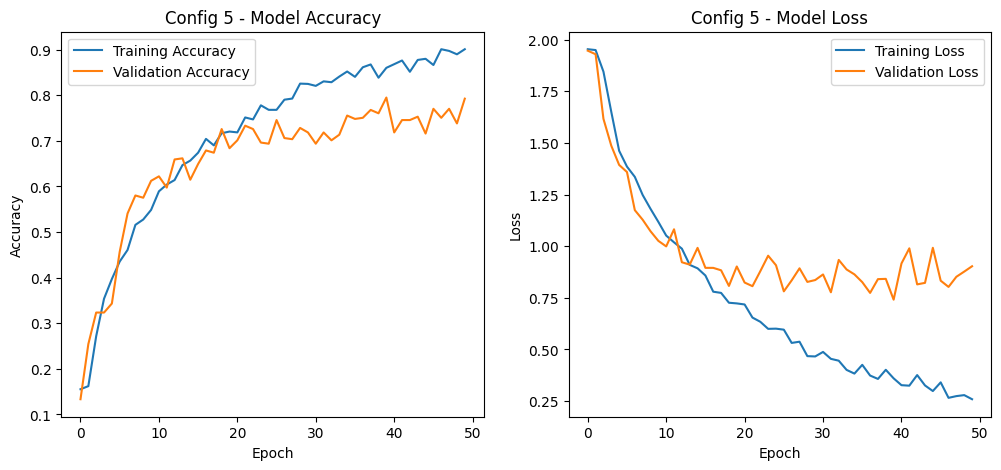

Top 6 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 76.05%, Precision: 0.9435, Recall: 0.9709, F1 Score: 0.9570


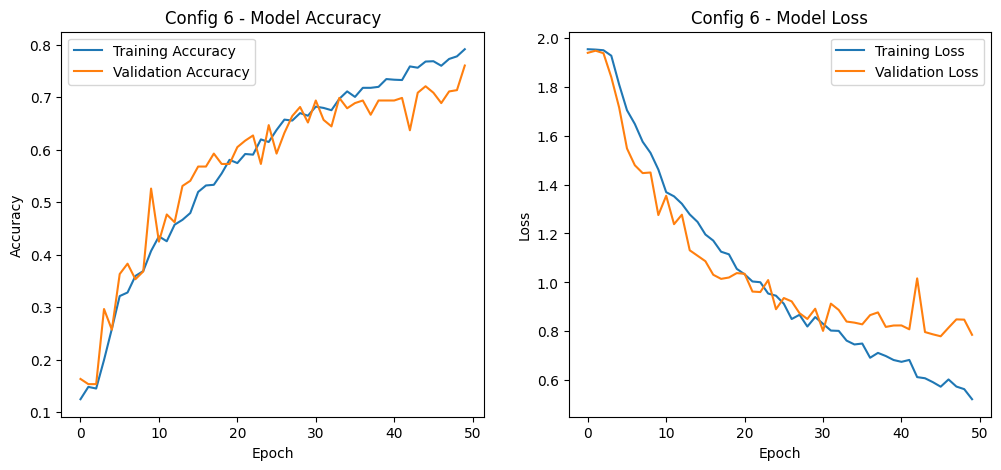

Top 7 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 73.09%, Precision: 0.9408, Recall: 0.9709, F1 Score: 0.9557


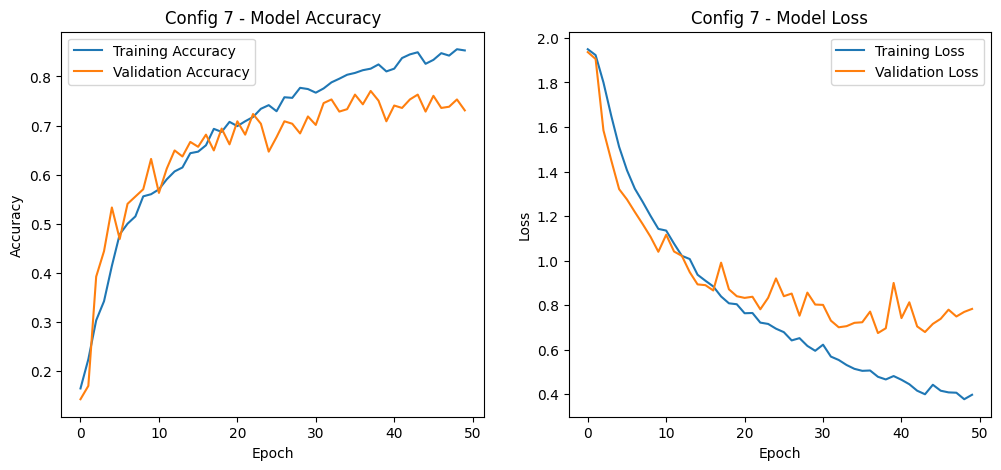

Top 8 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 76.30%, Precision: 0.9510, Recall: 0.9593, F1 Score: 0.9551


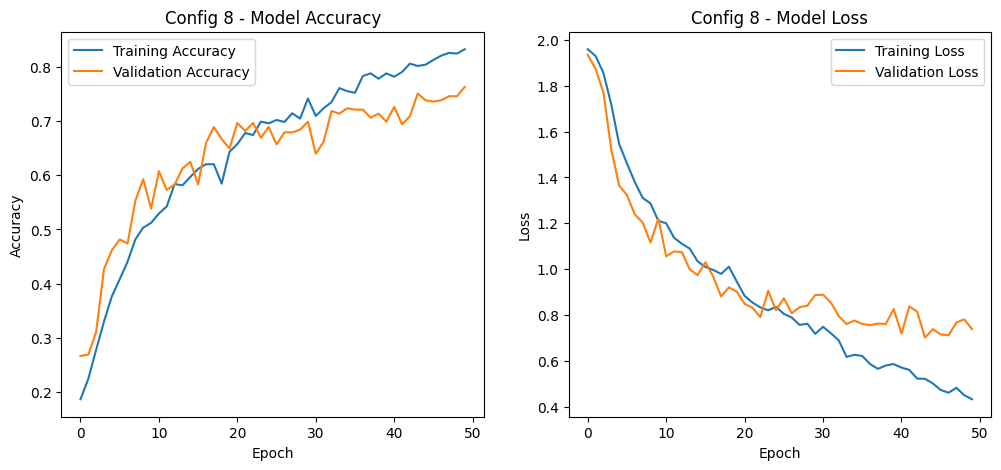

Top 9 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 73.33%, Precision: 0.9309, Recall: 0.9797, F1 Score: 0.9547


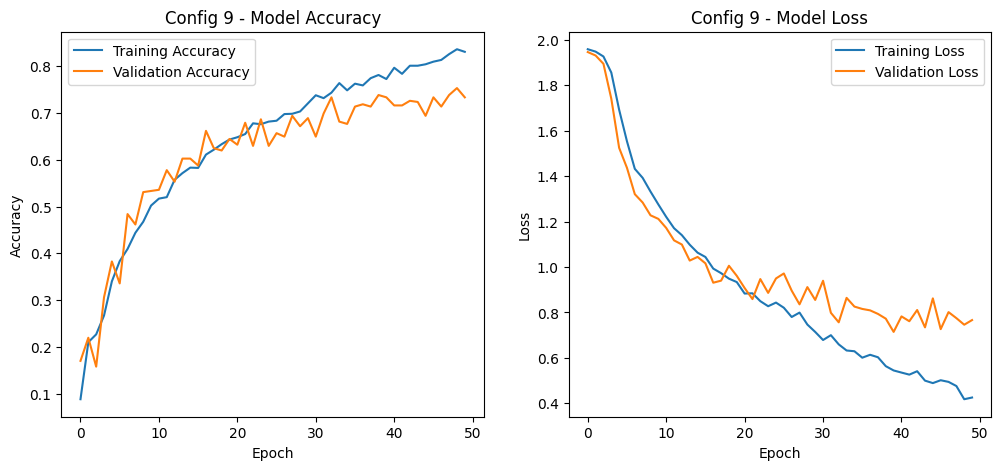

Top 10 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 75.56%, Precision: 0.9382, Recall: 0.9709, F1 Score: 0.9543


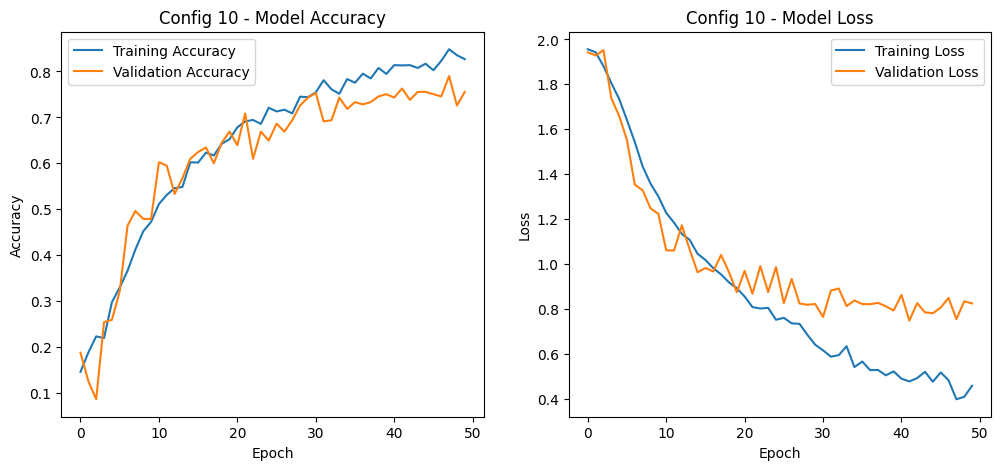

Top 11 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 72.84%, Precision: 0.9260, Recall: 0.9826, F1 Score: 0.9535


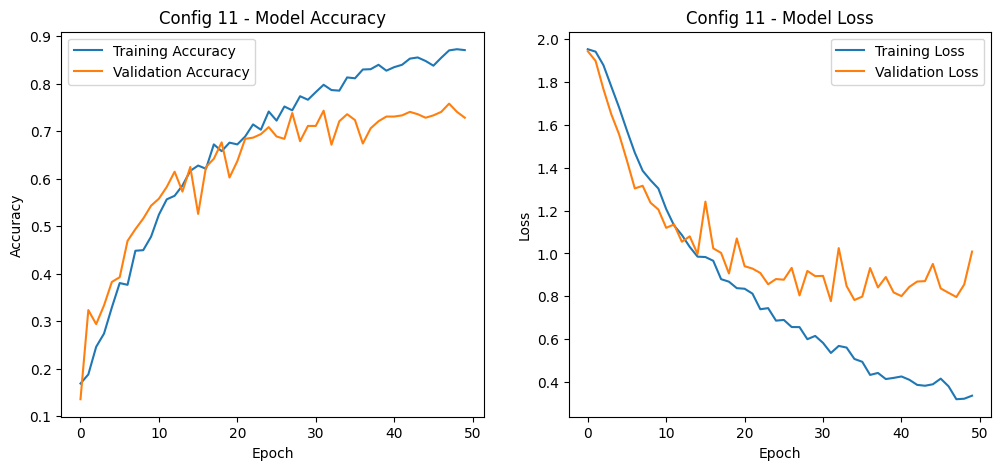

Top 12 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 71.85%, Precision: 0.9235, Recall: 0.9826, F1 Score: 0.9521


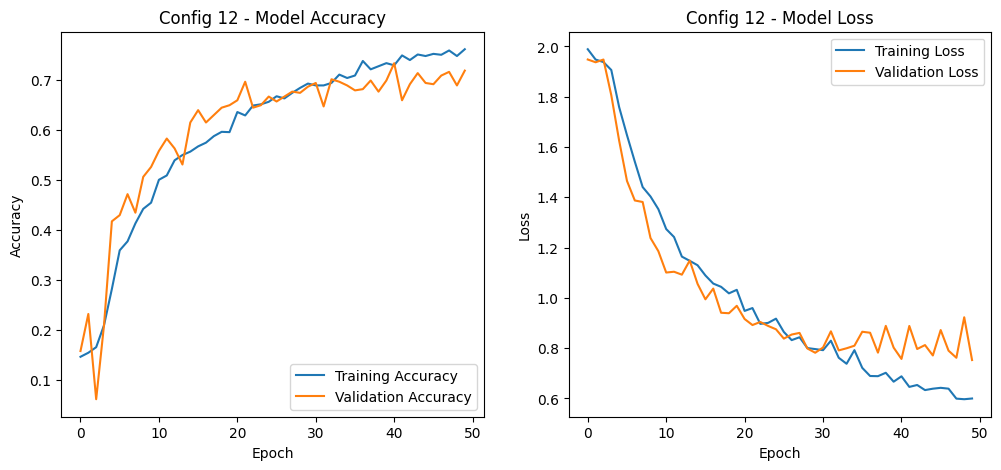

Top 13 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 73.58%, Precision: 0.9507, Recall: 0.9535, F1 Score: 0.9521


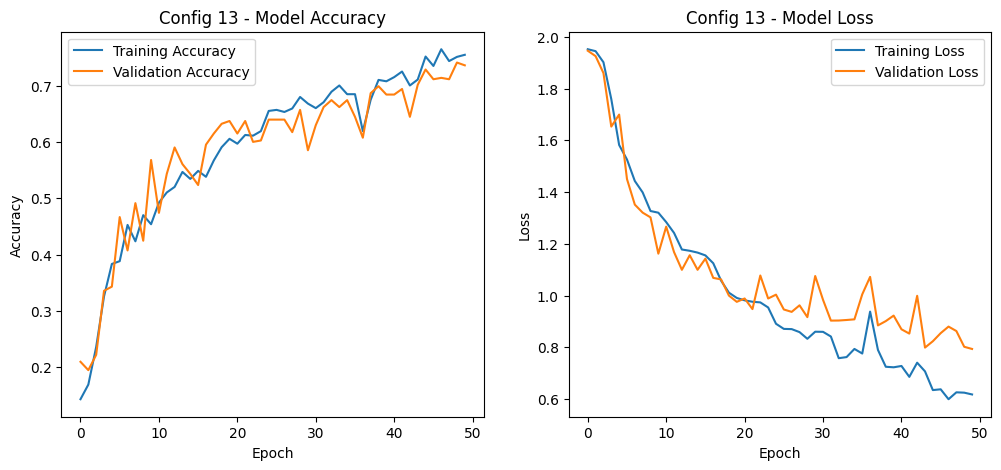

Top 14 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 76.30%, Precision: 0.9534, Recall: 0.9506, F1 Score: 0.9520


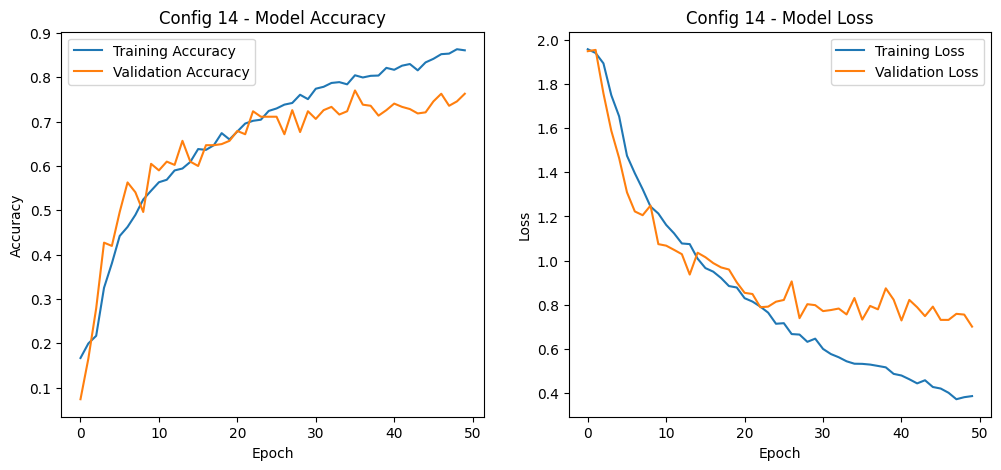

Top 15 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 75.31%, Precision: 0.9379, Recall: 0.9651, F1 Score: 0.9513


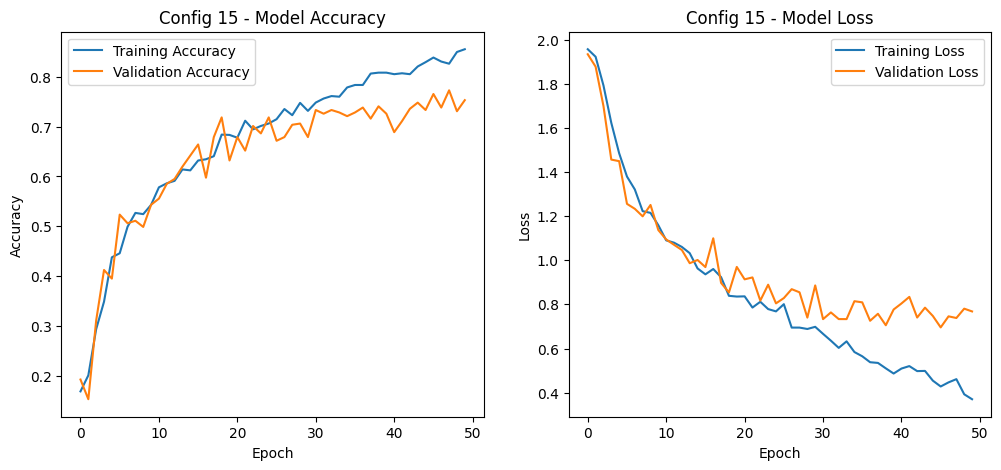

Top 16 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 72.84%, Precision: 0.9480, Recall: 0.9535, F1 Score: 0.9507


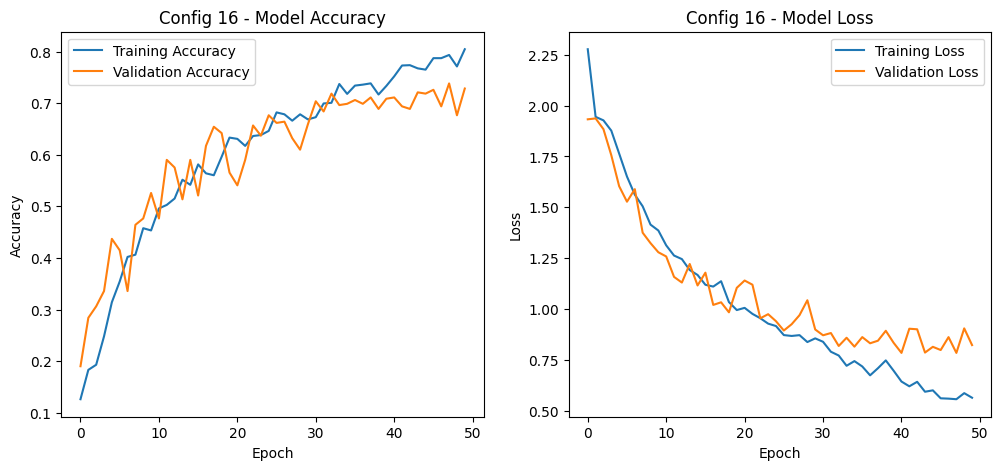

Top 17 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 72.10%, Precision: 0.9377, Recall: 0.9622, F1 Score: 0.9498


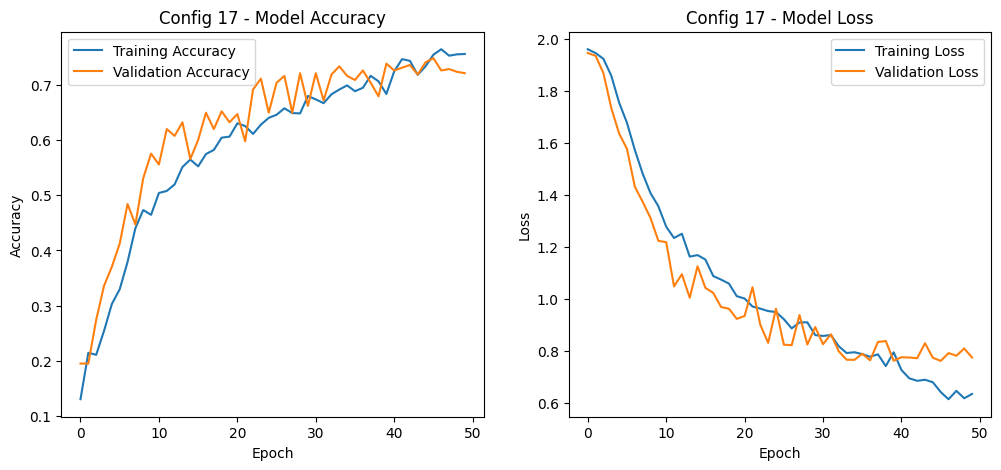

Top 18 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 77.78%, Precision: 0.9402, Recall: 0.9593, F1 Score: 0.9496


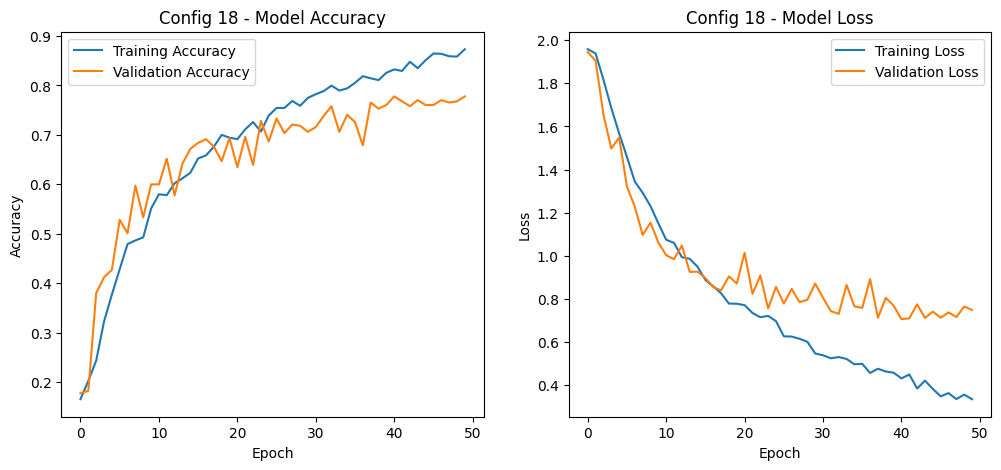

Top 19 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 74.07%, Precision: 0.9254, Recall: 0.9738, F1 Score: 0.9490


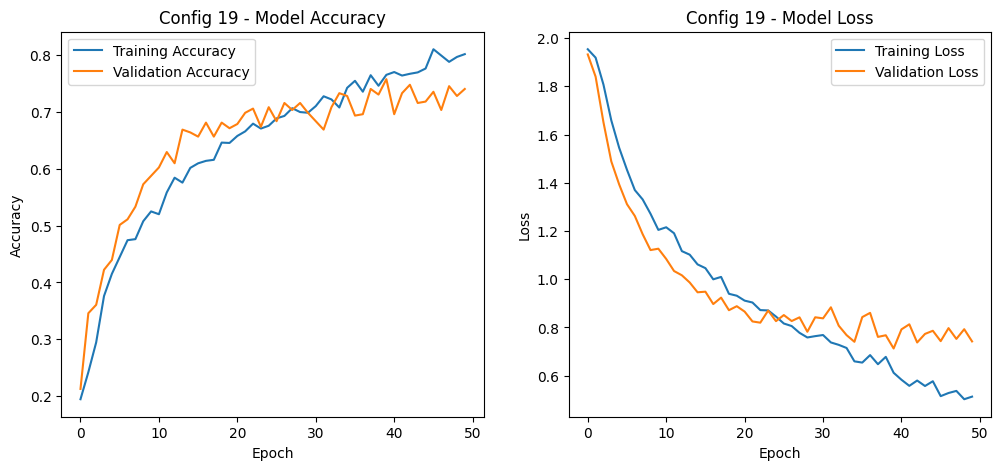

Top 20 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 71.36%, Precision: 0.9326, Recall: 0.9651, F1 Score: 0.9486


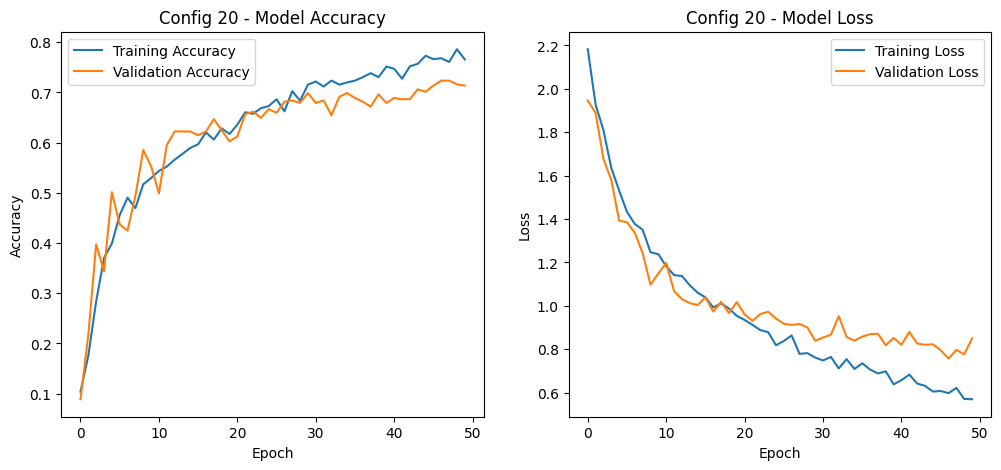

Top 21 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 74.07%, Precision: 0.9326, Recall: 0.9651, F1 Score: 0.9486


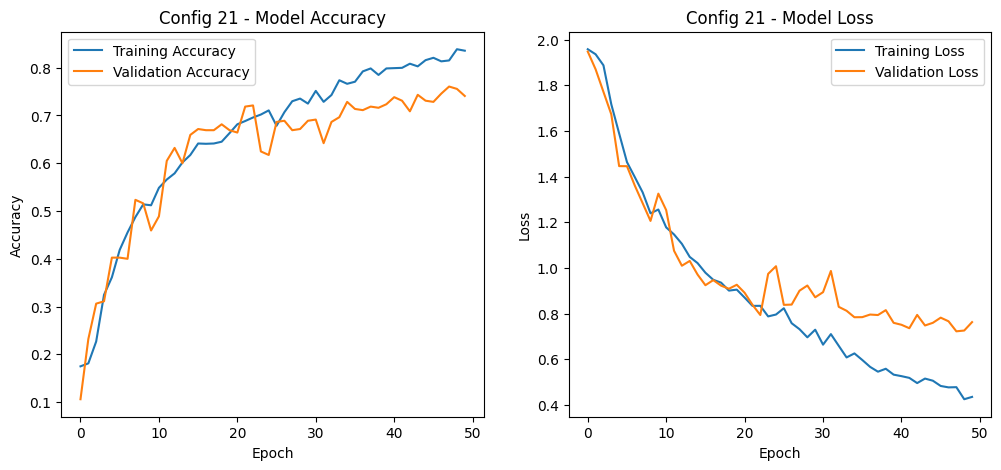

Top 22 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 72.59%, Precision: 0.9375, Recall: 0.9593, F1 Score: 0.9483


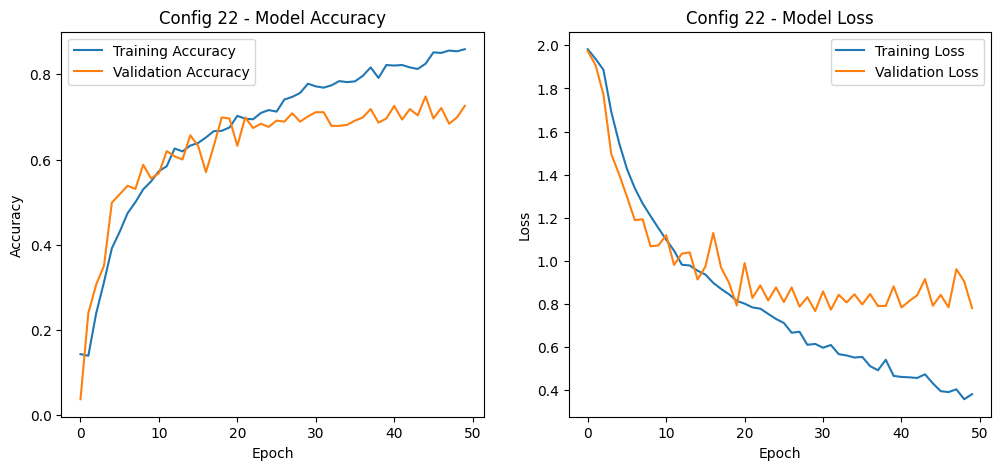

Top 23 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 69.14%, Precision: 0.9451, Recall: 0.9506, F1 Score: 0.9478


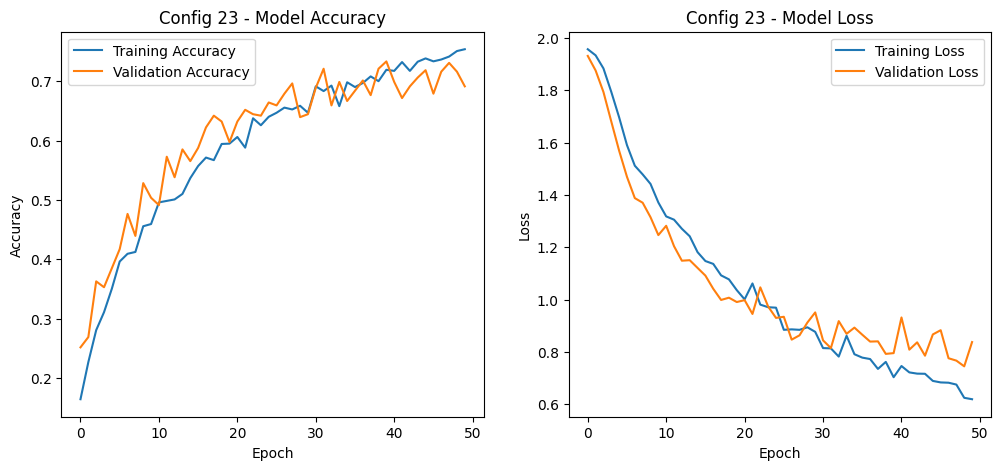

Top 24 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 71.60%, Precision: 0.9451, Recall: 0.9506, F1 Score: 0.9478


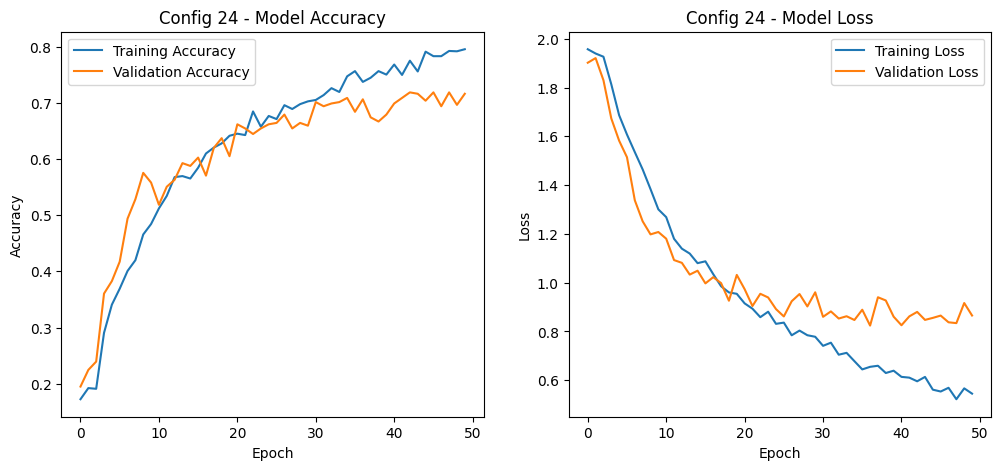

Top 25 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 73.58%, Precision: 0.9477, Recall: 0.9477, F1 Score: 0.9477


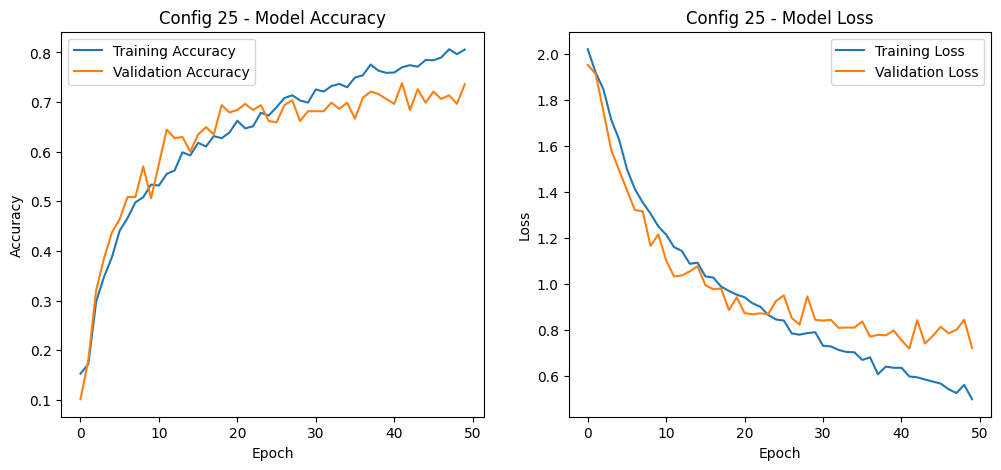

Top 26 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 71.85%, Precision: 0.9229, Recall: 0.9738, F1 Score: 0.9477


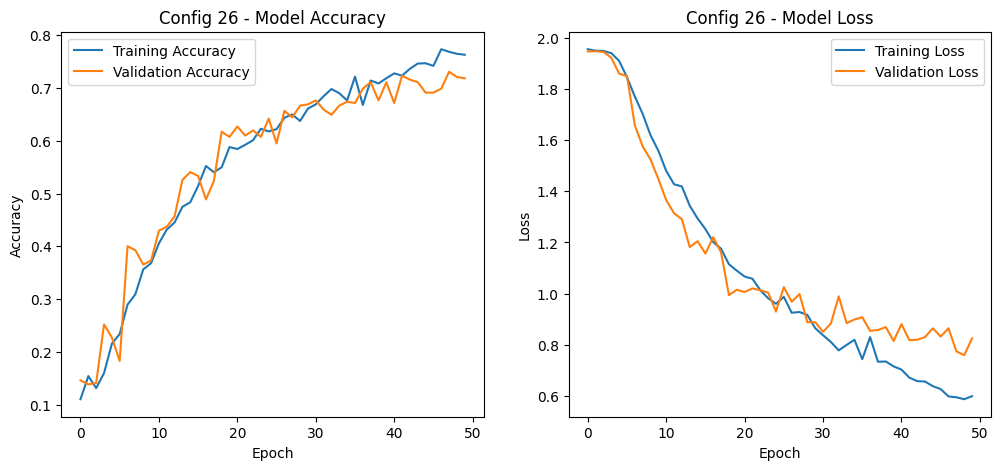

Top 27 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 68.15%, Precision: 0.9300, Recall: 0.9651, F1 Score: 0.9472


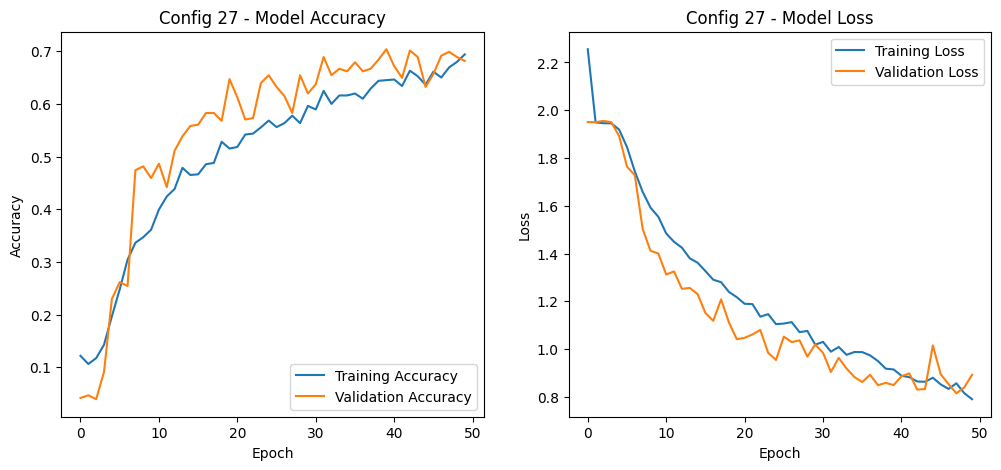

Top 28 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 72.59%, Precision: 0.9300, Recall: 0.9651, F1 Score: 0.9472


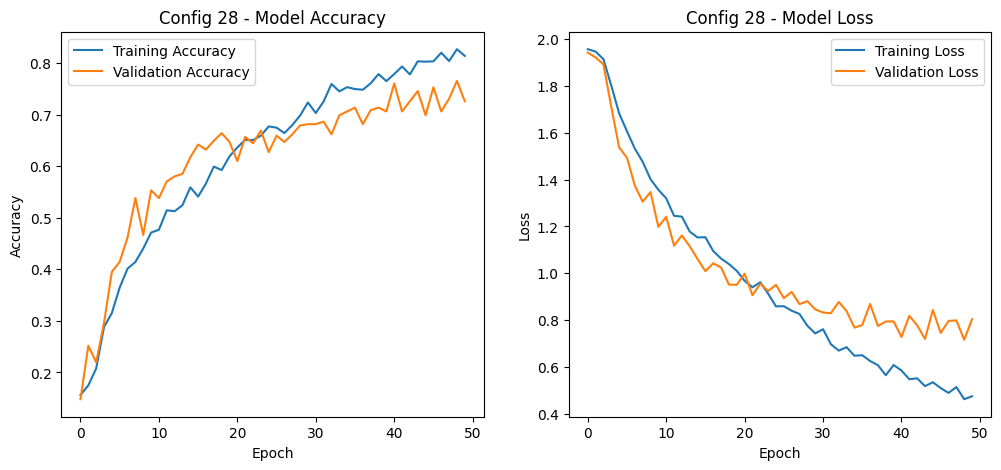

Top 29 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 72.10%, Precision: 0.9180, Recall: 0.9767, F1 Score: 0.9465


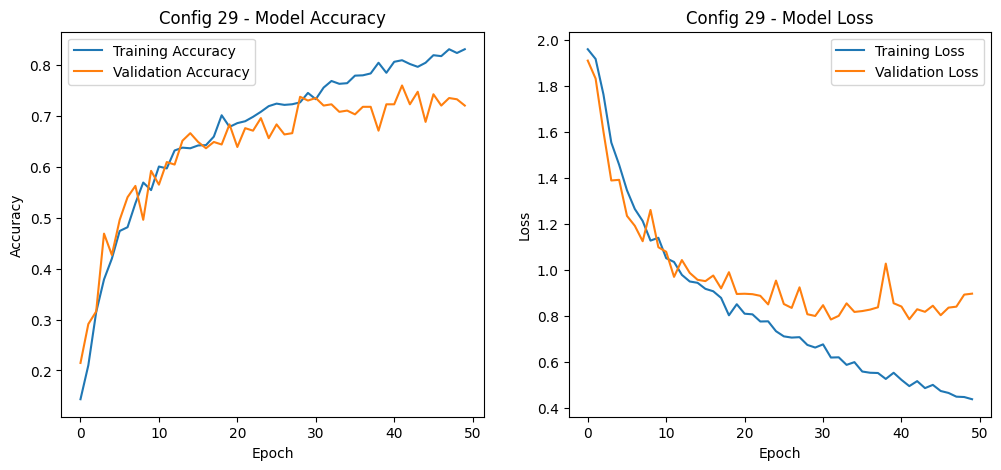

Top 30 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 74.81%, Precision: 0.9424, Recall: 0.9506, F1 Score: 0.9465


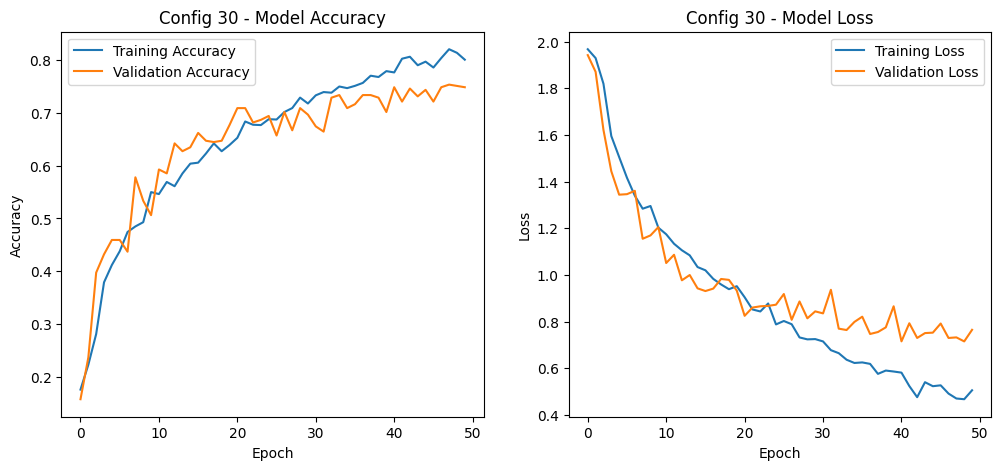

Top 31 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 71.85%, Precision: 0.9250, Recall: 0.9680, F1 Score: 0.9460


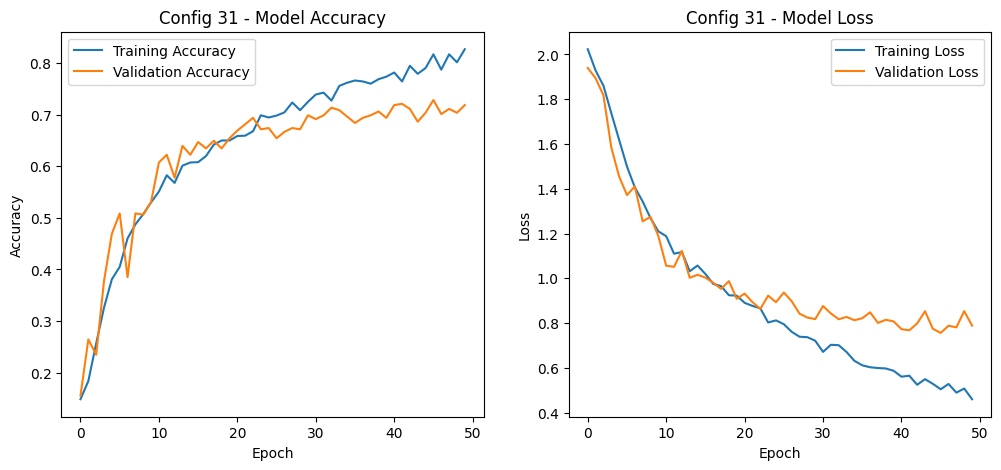

Top 32 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 71.60%, Precision: 0.9274, Recall: 0.9651, F1 Score: 0.9459


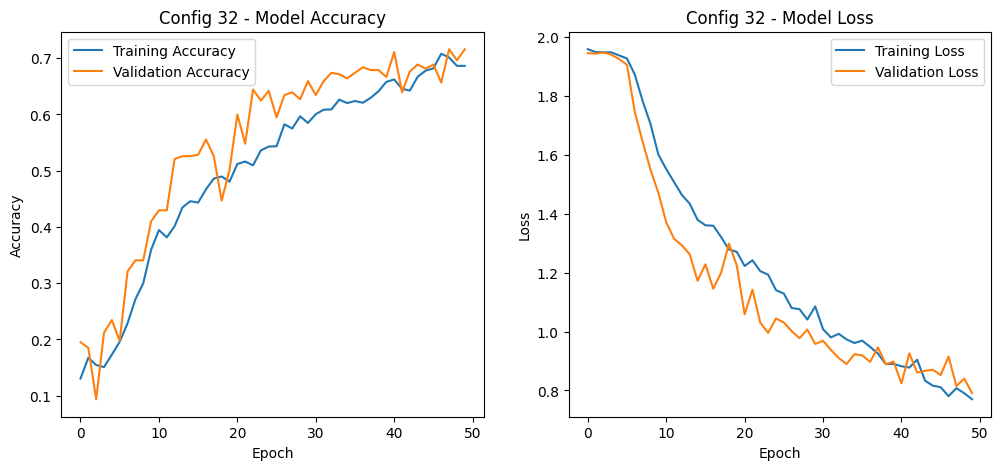

Top 33 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 70.37%, Precision: 0.9555, Recall: 0.9360, F1 Score: 0.9457


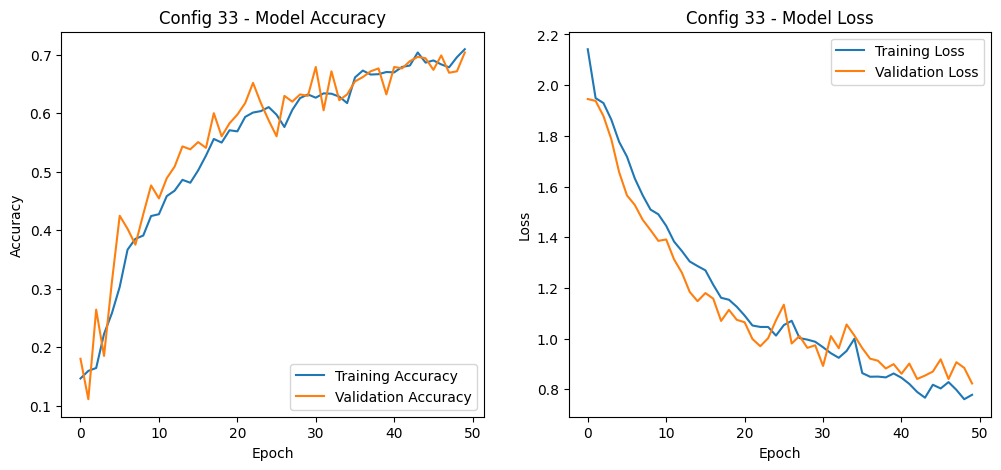

Top 34 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 74.32%, Precision: 0.9582, Recall: 0.9331, F1 Score: 0.9455


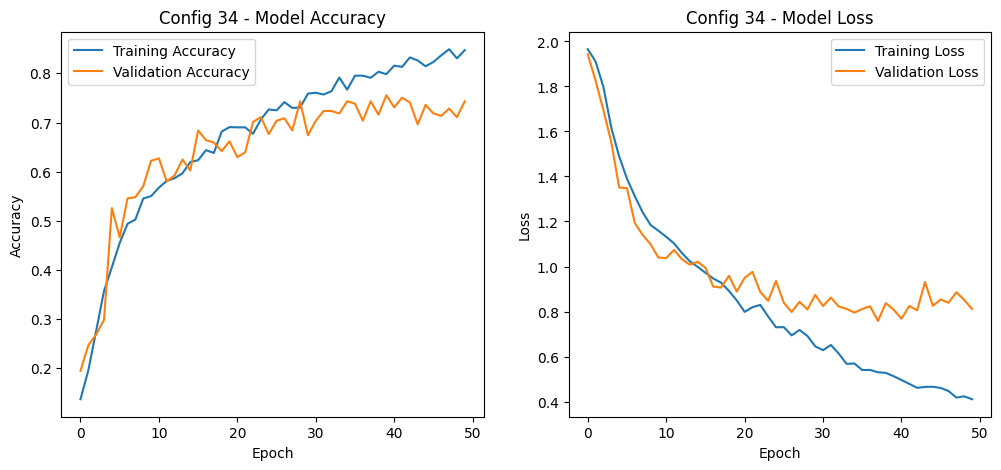

Top 35 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 69.63%, Precision: 0.9111, Recall: 0.9826, F1 Score: 0.9455


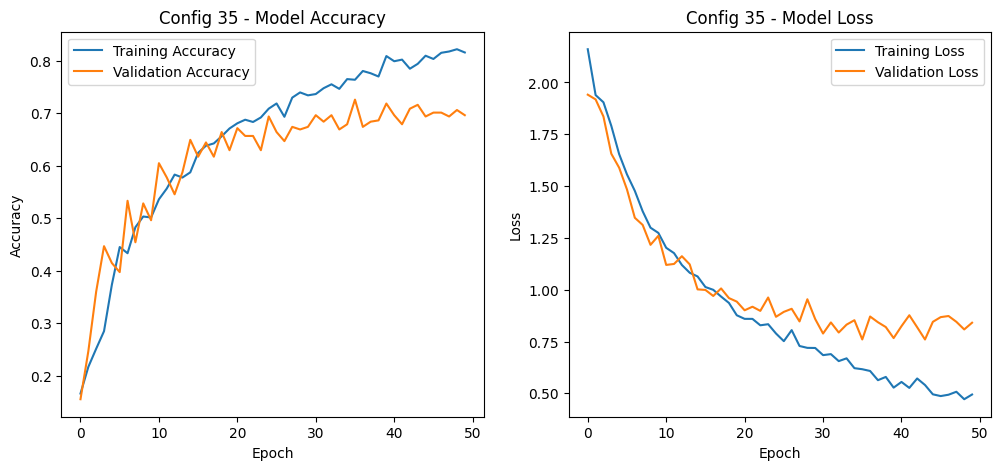

Top 36 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 70.62%, Precision: 0.9111, Recall: 0.9826, F1 Score: 0.9455


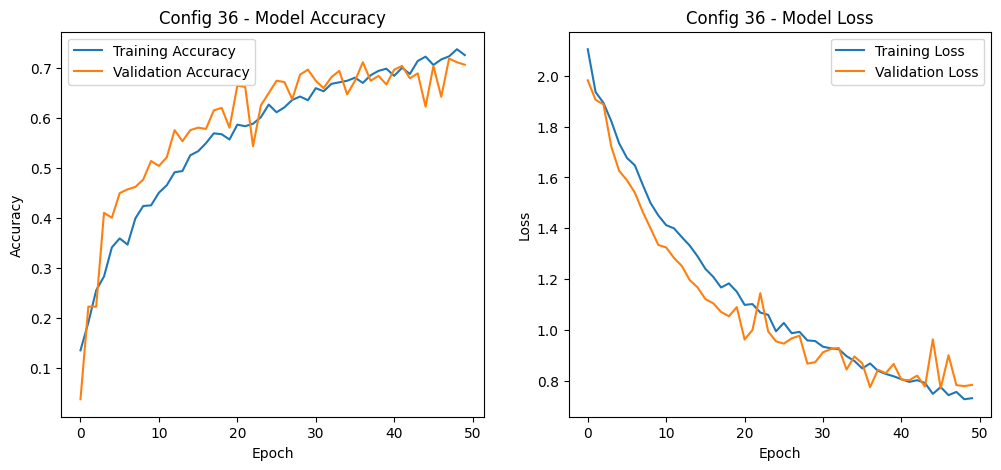

Top 37 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 68.15%, Precision: 0.9111, Recall: 0.9826, F1 Score: 0.9455


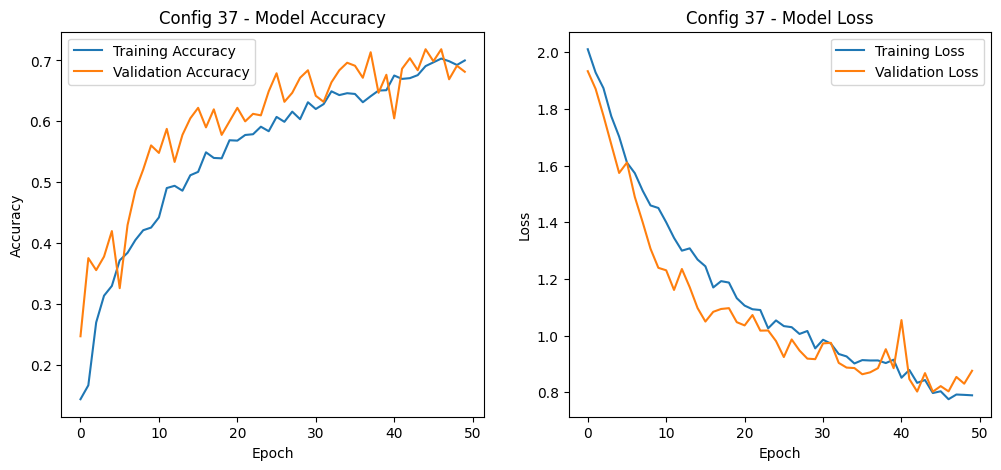

Top 38 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 71.36%, Precision: 0.9111, Recall: 0.9826, F1 Score: 0.9455


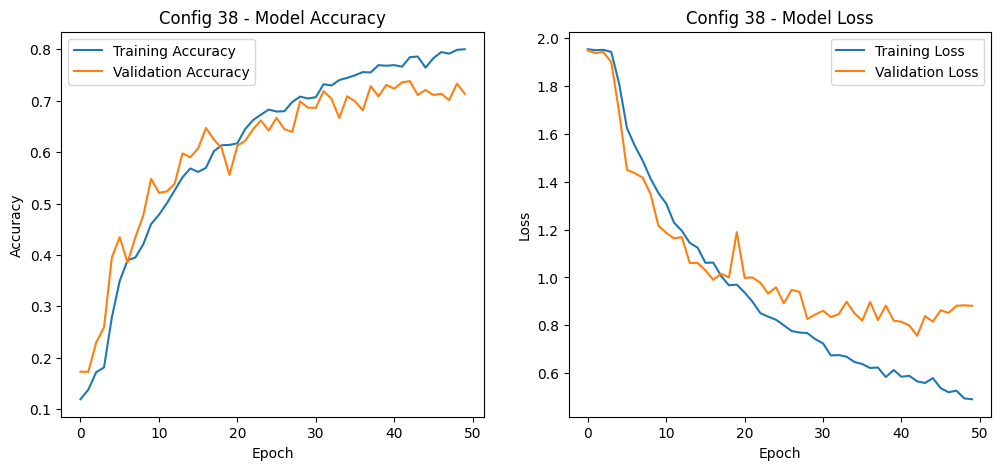

Top 39 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 72.84%, Precision: 0.9371, Recall: 0.9535, F1 Score: 0.9452


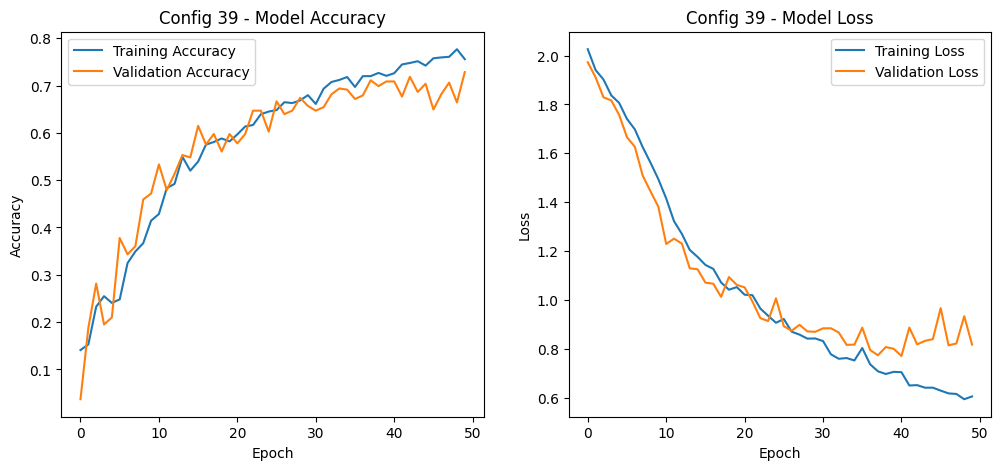

Top 40 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 70.37%, Precision: 0.9397, Recall: 0.9506, F1 Score: 0.9451


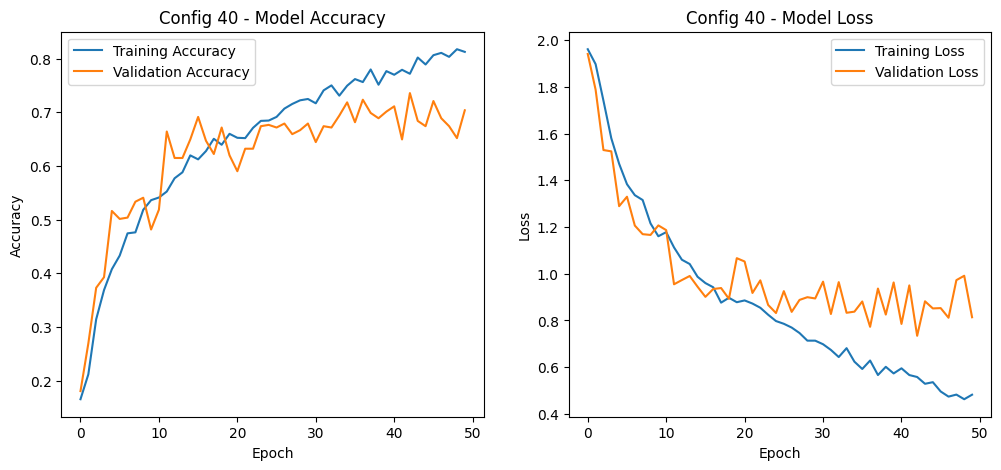

Top 41 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.3, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 67.65%, Precision: 0.9397, Recall: 0.9506, F1 Score: 0.9451


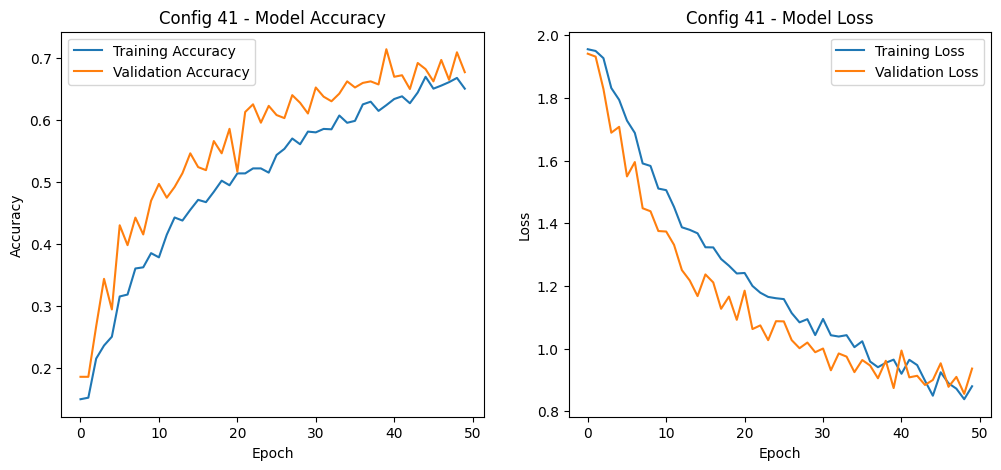

Top 42 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 64.44%, Precision: 0.9201, Recall: 0.9709, F1 Score: 0.9448


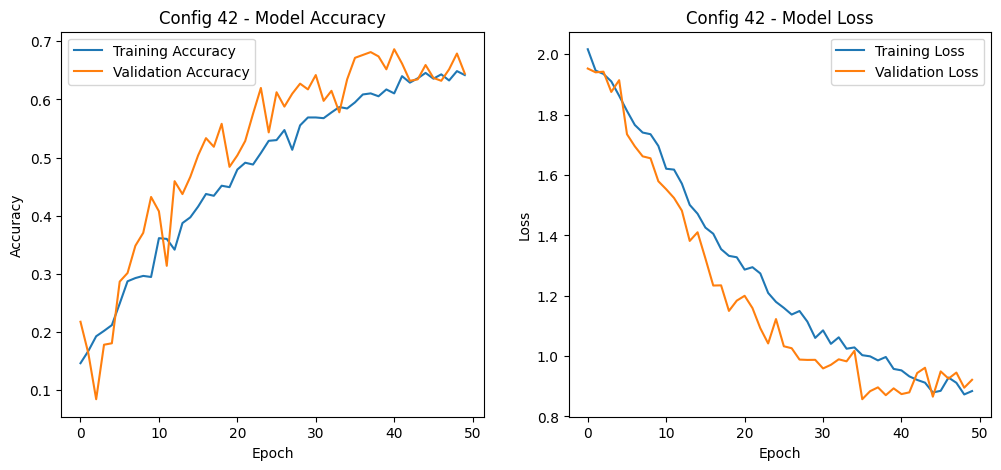

Top 43 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 66.42%, Precision: 0.9224, Recall: 0.9680, F1 Score: 0.9447


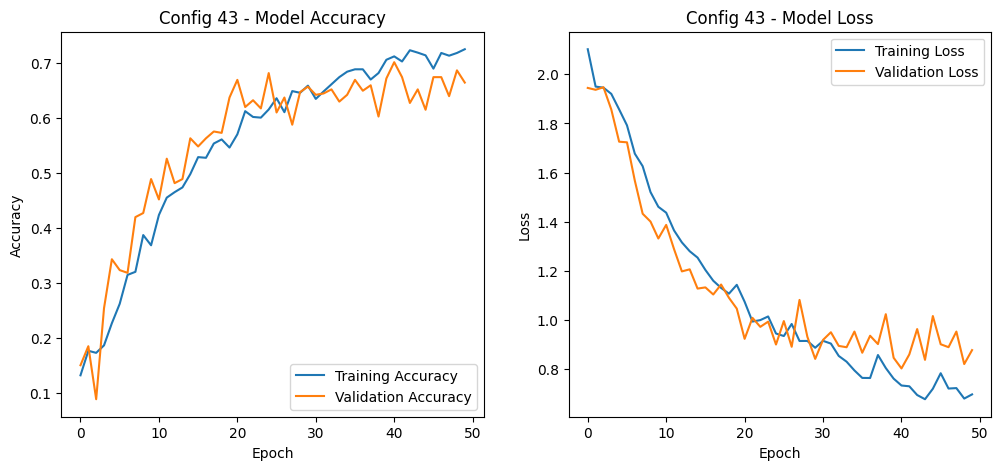

Top 44 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 68.89%, Precision: 0.9224, Recall: 0.9680, F1 Score: 0.9447


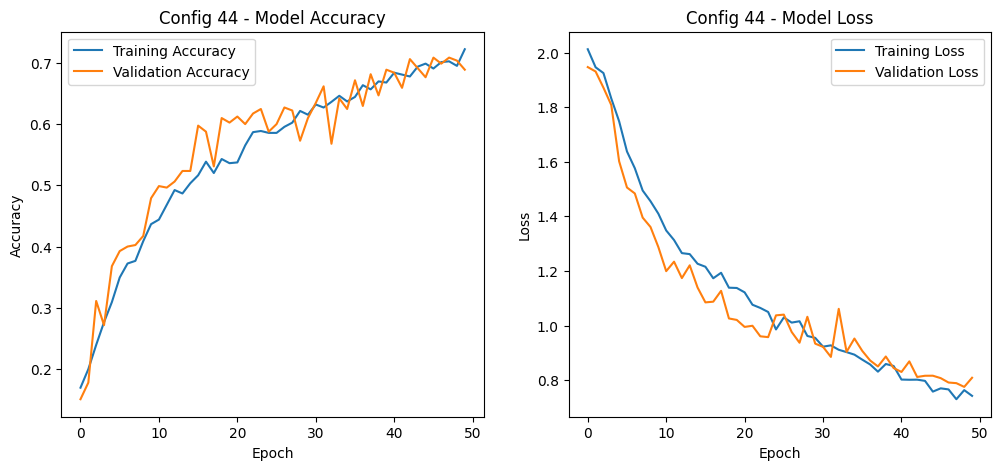

Top 45 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 72.35%, Precision: 0.9474, Recall: 0.9419, F1 Score: 0.9446


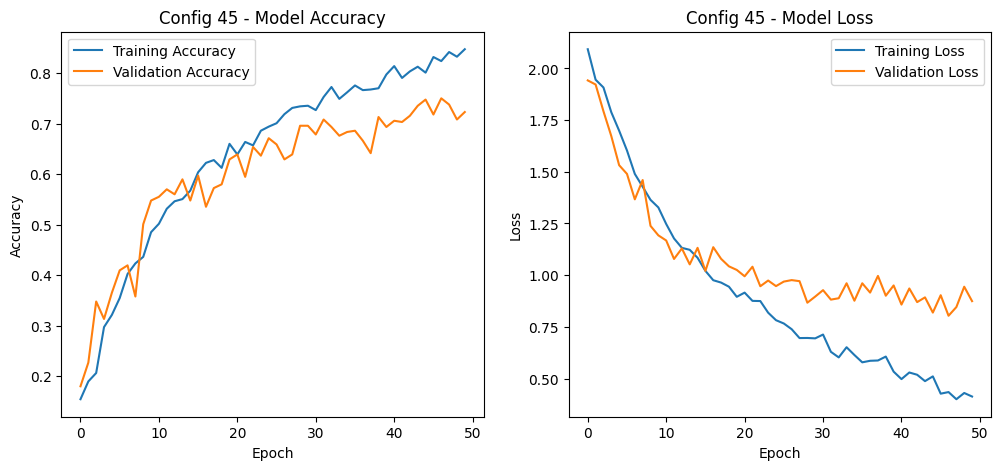

Top 46 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 69.38%, Precision: 0.9272, Recall: 0.9622, F1 Score: 0.9444


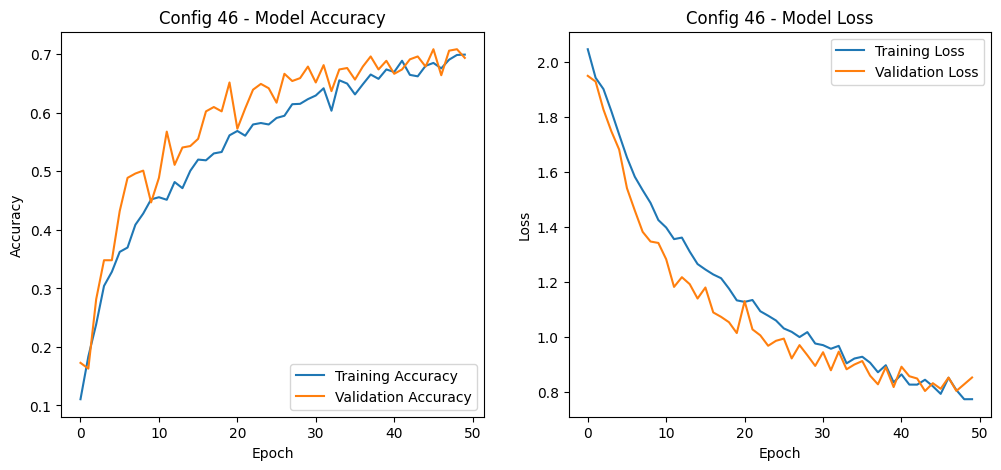

Top 47 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 68.64%, Precision: 0.9345, Recall: 0.9535, F1 Score: 0.9439


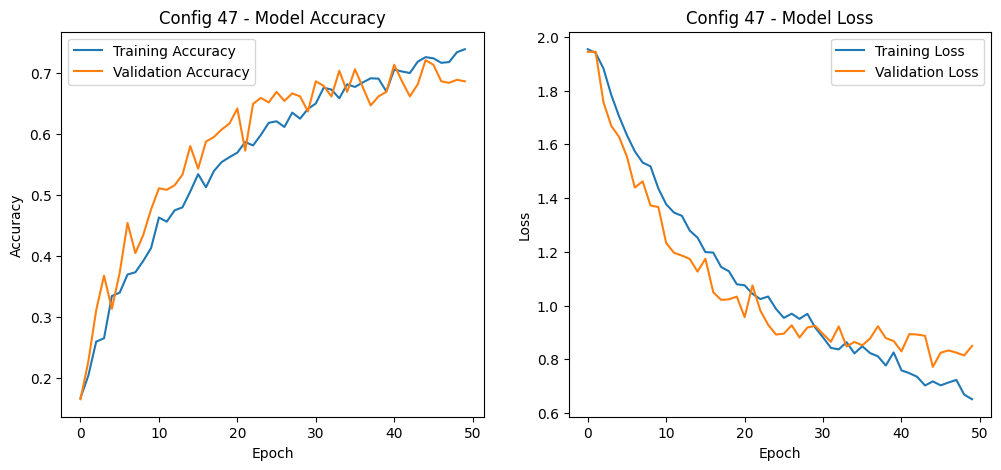

Top 48 Configuration: {'conv_layers': 1, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 74.81%, Precision: 0.9370, Recall: 0.9506, F1 Score: 0.9437


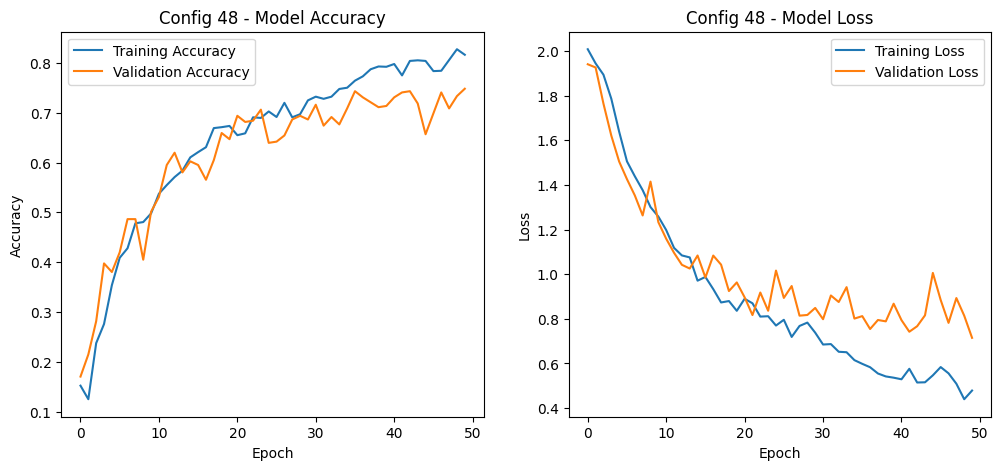

Top 49 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 68.89%, Precision: 0.9153, Recall: 0.9738, F1 Score: 0.9437


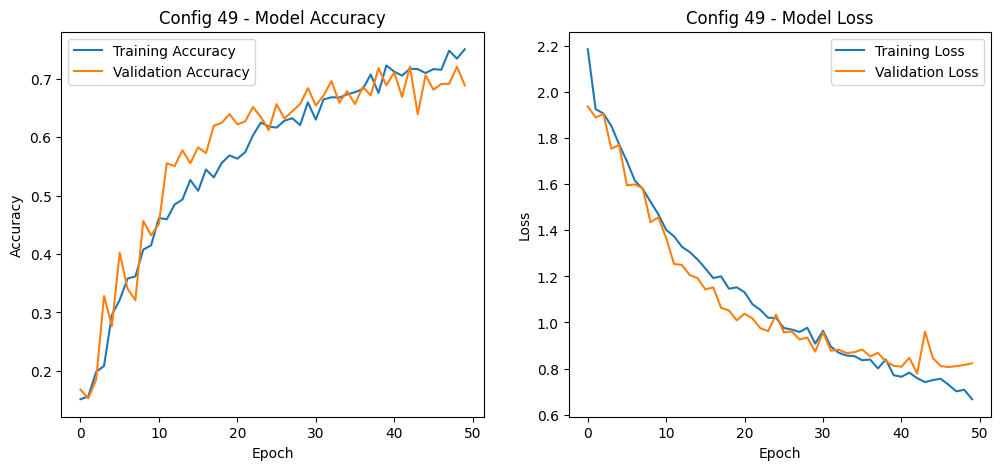

Top 50 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 70.86%, Precision: 0.9153, Recall: 0.9738, F1 Score: 0.9437


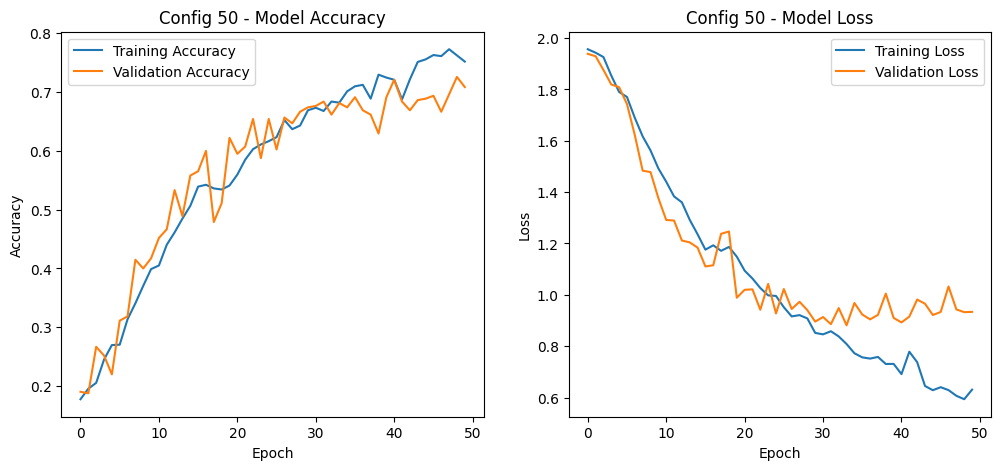

Top 51 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 71.11%, Precision: 0.9395, Recall: 0.9477, F1 Score: 0.9436


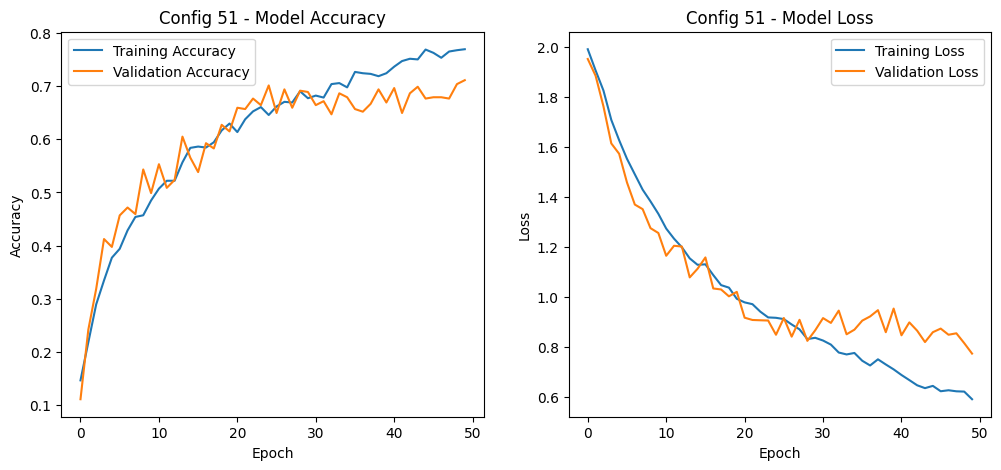

Top 52 Configuration: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 64, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 74.57%, Precision: 0.9395, Recall: 0.9477, F1 Score: 0.9436


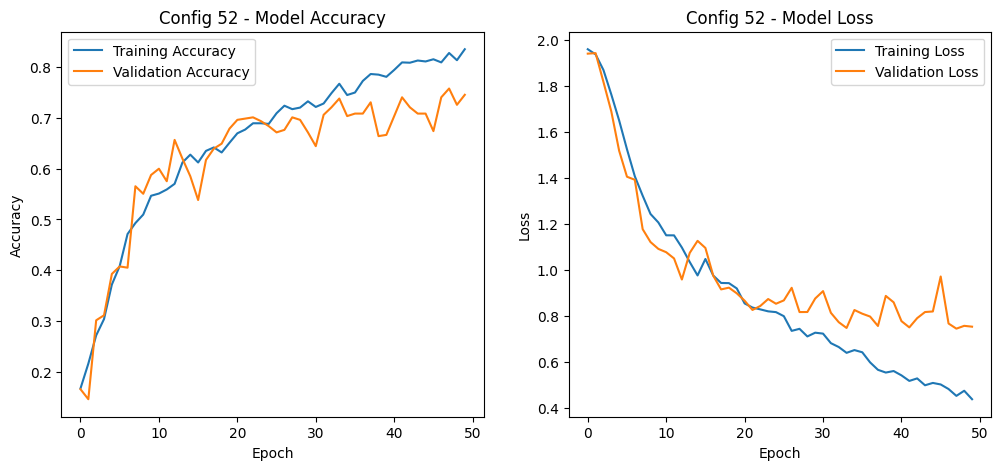

Top 53 Configuration: {'conv_layers': 1, 'filters': 64, 'dense_layers': 2, 'dense_units': 64, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 69.63%, Precision: 0.9176, Recall: 0.9709, F1 Score: 0.9435


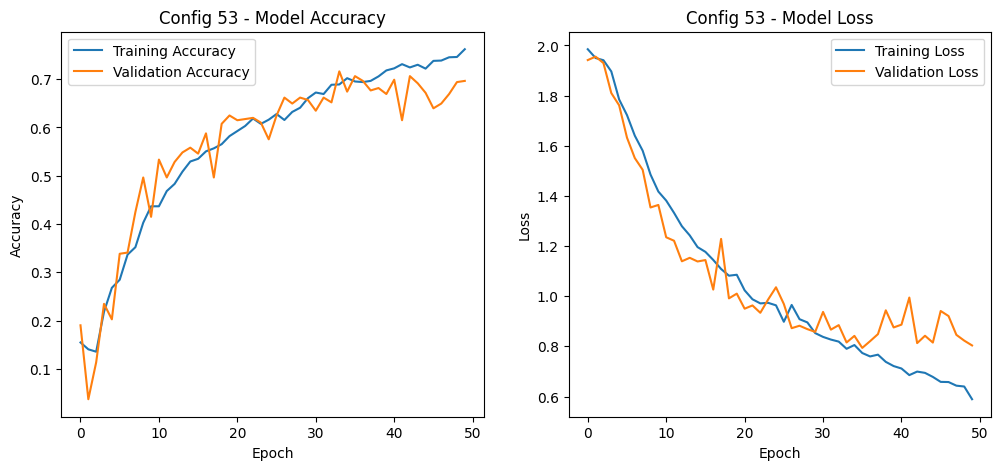

Top 54 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 74.57%, Precision: 0.9665, Recall: 0.9215, F1 Score: 0.9435


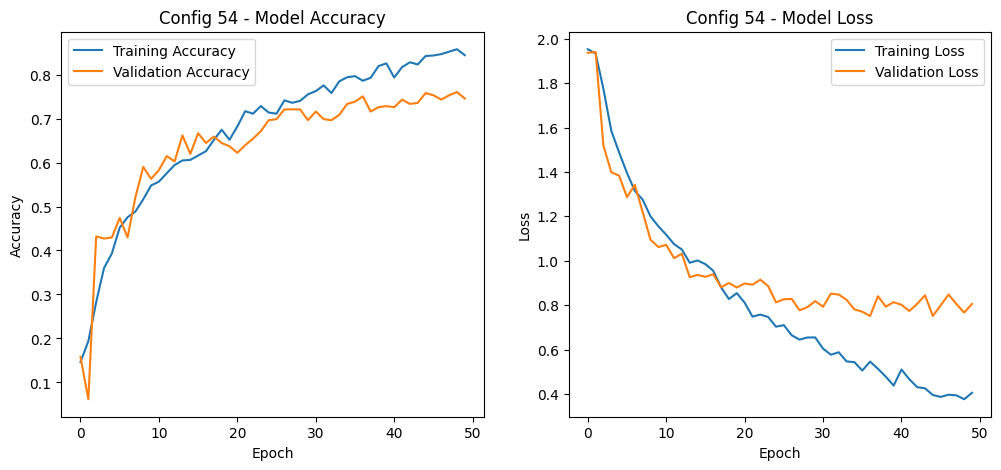

Top 55 Configuration: {'conv_layers': 2, 'filters': 32, 'dense_layers': 2, 'dense_units': 128, 'dropout': 0.3, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Metrics - Accuracy: 72.35%, Precision: 0.9199, Recall: 0.9680, F1 Score: 0.9433


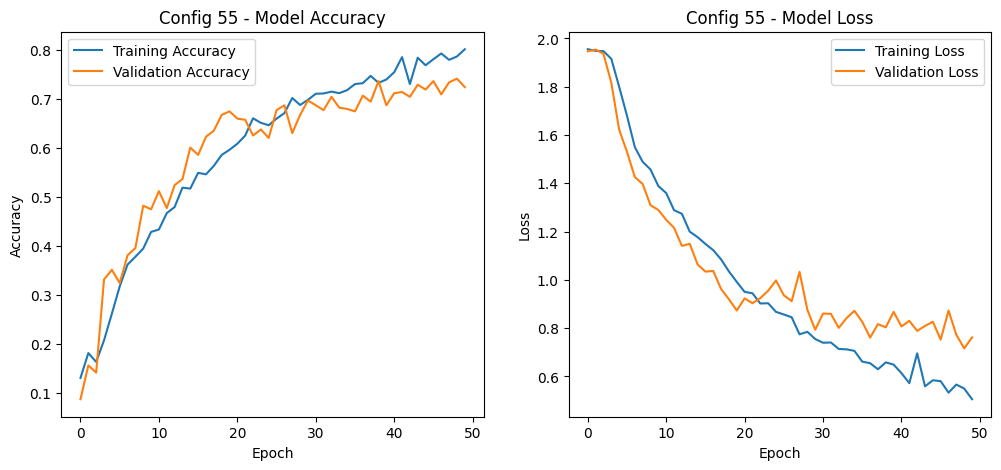

In [5]:
# Sort results by F1 score in descending order and select the top 15
top_results = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:55]

# Print and plot the top 15 results
for idx, result in enumerate(top_results):
    config = result['config']
    history = result['history']
    print(f"Top {idx+1} Configuration: {config}")
    print(f"Metrics - Accuracy: {result['test_accuracy']*100:.2f}%, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, F1 Score: {result['f1_score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Config {idx+1} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Config {idx+1} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
